In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import math
import random
from geopy import distance
import swmmio
import pyswmm
from pyswmm import Simulation,Subcatchments
import math
import pickle
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point, box
import tifffile
import rasterio
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio.enums import Resampling
import os   

EPSG:25833
BoundingBox(left=391688.1352, bottom=5816723.5617, right=394900.3042, top=5819450.5491)
(array([   0,    0,    0, ..., 2726, 2726, 2726], dtype=int64), array([   0,    1,    2, ..., 3209, 3210, 3211], dtype=int64))


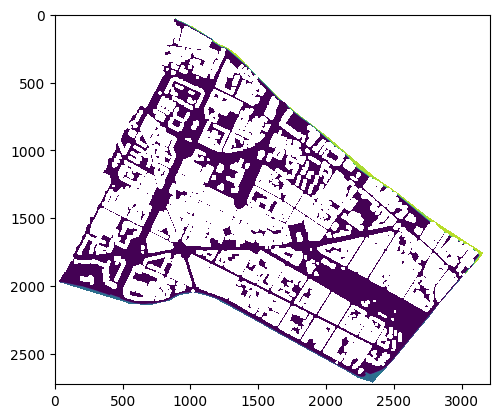

In [2]:

path_slf = "C:/Lehre/Austausch/x_Mahajan/swmm2tel/bln1/bln1_buffer_CN100.slf"
x_shift = 391000
y_shift = 5815000

path_tif = "C:/Users/sylvi/Documents/Hyspec4EO/for_dsieo/r2d_bln1_swmm_e1_1y_0H.tif"
data= tifffile.imread(path_tif)
map=rasterio.open(path_tif)
print(map.crs)
print(map.bounds)
extent1 = [map.bounds[0], map.bounds[1], map.bounds[2], map.bounds[3]]
print(np.where(data!='nan'))
plt.imshow(data)
plt.show()

c:\Users\sylvi\Documents\Hyspec4EO\for_dsieo\.conda\lib\site-packages\swmmio\utils\text.py:265: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  options = pd.read_csv(StringIO(ops_string), header=None,
c:\Users\sylvi\Documents\Hyspec4EO\for_dsieo\.conda\lib\site-packages\swmmio\utils\text.py:265: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  options = pd.read_csv(StringIO(ops_string), header=None,
c:\Users\sylvi\Documents\Hyspec4EO\for_dsieo\.conda\lib\site-packages\swmmio\utils\dataframes.py:167: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO(s), header=None, delim_whitespace=True,
c:\Users\sylvi\Documents\Hyspec4EO\for_dsieo\.conda\lib\site-packages\swmmio\utils\text.py:265

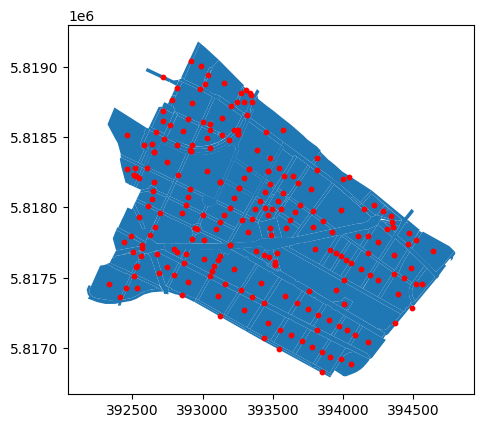

In [3]:
# Define the paths to SWMM model files
inp_file = 'C:/Users/sylvi/Documents/Hyspec4EO/for_dsieo/for_dsieo/Berlin_I.inp'

# Import the SWMM model
Bln_1_model=swmmio.Model(inp_file)
subs=Bln_1_model.subcatchments.dataframe
# Reset the index to add the Name of the subcatchments as a column to the dataframe
subs = subs.reset_index()

# convert the coordinates to a polygon coordination that can be used by geopandas
subs['geometry']=subs['coords'].apply(lambda coords: Polygon(coords))

# Create a GeoDataFrame with the specified CRS
subs = gpd.GeoDataFrame(subs, geometry='geometry', crs='EPSG:25833')

# drop unnecessary data
subs.drop(columns=['Raingage', 'Outlet', 'PercImperv', 'Width',
       'PercSlope', 'CurbLength', 'N-Imperv', 'N-Perv', 'S-Imperv', 'S-Perv',
       'PctZero', 'RouteTo', 'PctRouted', 
        'coords', 'Area'],inplace=True)


# Create a new column with the center points of the polygons
subs['center_point'] = subs['geometry'].centroid
# Plot the GeoDataFrame
ax = subs.plot()

# Plot the center points on the same plot
subs['center_point'].plot(ax=ax, color='red', markersize=10)

extent2 = subs.total_bounds
extent = [min(extent1[0],extent2[0]), min(extent1[1],extent2[1]), max(extent1[2],extent2[2]), max(extent1[3],extent2[3])]

In [4]:
def sum_data_5min(data):
    t=len(data)
    timestep = 10
    output = np.zeros((math.ceil(t/timestep)))
    for i in range(0,math.ceil(t/timestep)):
        output[i] = np.sum(data[i*timestep:(i+1)*timestep])
    return output


def get_nearest_runoff_value(px,py,data_txt_sum,subs,extent):
    x = px+extent[0]
    y = py+extent[1]
    point = Point(x,y)
    points = subs['center_point']
    distances = points.distance(point)
    nearest_point_id = distances.idxmin()
    return data_txt_sum[nearest_point_id]

#save to tif with projection


def save_to_tif(extent,file_path,image):

    # Set the transform with the upper left corner and the pixel size
    transform = from_origin(extent[0], extent[3], 1, 1)
    save_new_map = image.transpose(2,0,1)
    # Set the metadata
    meta = {
    'driver': 'GTiff',
    'height': save_new_map.shape[1],
    'width': save_new_map.shape[2],
    'count': save_new_map.shape[0],
    'dtype': save_new_map.dtype,
    'crs': CRS.from_epsg(25833),
    'transform': transform,
    'compress': 'lzw',
    'nodata': np.nan
    }

    # Write the raster to disk
    with rasterio.open(file_name, 'w', **meta) as dst:
        dst.write(save_new_map, indexes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
        dst.nodata =np.nan
        dst.crs = CRS.from_epsg(25833)
        dst.transform = transform
        dst.close()

    # Open the raster file
    with rasterio.open(file_name) as src:
        print(src.profile)
        print(src.crs)
        print(src.transform)
        print(src.bounds)
        print(src.width)
        print(src.height)
        print(src.count)
        print(src.nodata)
        data = src.read(1)
        plt.imshow(data)
        plt.show()

(231, 48)


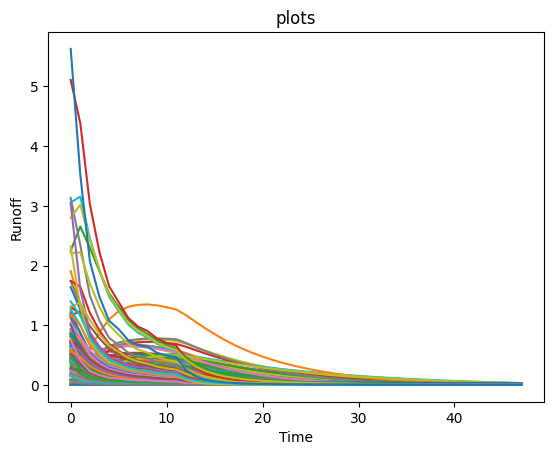

3212.1689999999944 2726.9873999999836


In [5]:
path = "C:/Users/sylvi/Documents/Hyspec4EO/for_dsieo/for_dsieo/runoff/"
path_save = "C:/Users/sylvi/Documents/Hyspec4EO/for_dsieo/for_dsieo/output/"
for file in os.listdir(path):
    if file.endswith(".txt"):
        mask = tifffile.imread('mask.tif')
        path_txt = os.path.join(path, file)
        data_txt = []
        data_txt_sum = []
        for point_id in subs.index:
            data_txt.append(np.loadtxt(path_txt, skiprows=1,usecols=point_id+1))
            data_txt_sum.append(sum_data_5min(data_txt[point_id]))
        data_txt = np.array(data_txt)
        data_txt_sum = np.array(data_txt_sum)
        print(data_txt_sum.shape)
        fig=plt.figure()
        ax = fig.add_subplot(111)
        ax.set_title('plots')
        ax.set_xlabel('Time')
        ax.set_ylabel('Runoff')
        for i in range(0,subs.shape[0]):
            ax.plot(data_txt_sum[i])

        plt.show()
        
        width = extent[2] - extent[0]
        height = extent[3] - extent[1]
        print(width,height)
        new_map = np.zeros((math.ceil(height),math.ceil(width),data_txt_sum.shape[1]))

        for px in range(0,math.ceil(width)):
            for py in range(0,math.ceil(height)):
                new_map[math.ceil(height)-py-1,px] = get_nearest_runoff_value(px,py,data_txt_sum,subs,extent)
        output= np.zeros((new_map.shape[0],new_map.shape[1],new_map.shape[2]))
        output[np.where(mask==1)]=new_map[np.where(mask==1)]
        output[np.where(mask==0)]=np.nan
        file_name = os.path.join(path_save, file[:-4]+".tif")
        save_to_tif(extent,file_name,output)

In [7]:
indexs= np.where(mask==1)
indexs2= np.where(mask==0)
output= np.zeros((new_map.shape[0],new_map.shape[1],new_map.shape[2]))
output[indexs]=new_map[indexs]
output[indexs2]=np.nan
file= "e2_75mm_runoff_swmm_.txt"
file_name = os.path.join(path_save, file[:-4]+".tif")
save_to_tif(extent,file_name,output)

MemoryError: Unable to allocate 1.49 GiB for an array with shape (4165865, 48) and data type float64

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 3213, 'height': 2727, 'count': 48, 'crs': CRS.from_epsg(25833), 'transform': Affine(1.0, 0.0, 391688.1352,
       0.0, -1.0, 5819450.5491), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}
EPSG:25833
| 1.00, 0.00, 391688.14|
| 0.00,-1.00, 5819450.55|
| 0.00, 0.00, 1.00|
BoundingBox(left=391688.1352, bottom=5816723.5491, right=394901.1352, top=5819450.5491)
3213
2727
48
nan


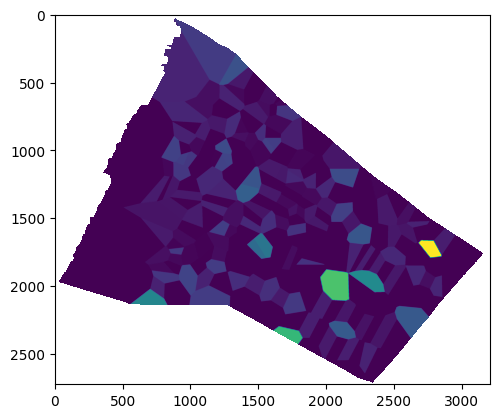

In [18]:
file_name = 'C:/Users/sylvi/Documents/Hyspec4EO/for_dsieo/for_dsieo/berlin_runoff5.tif'
save_to_tif(extent,file_name,output)

(231, 480)
(231, 48)


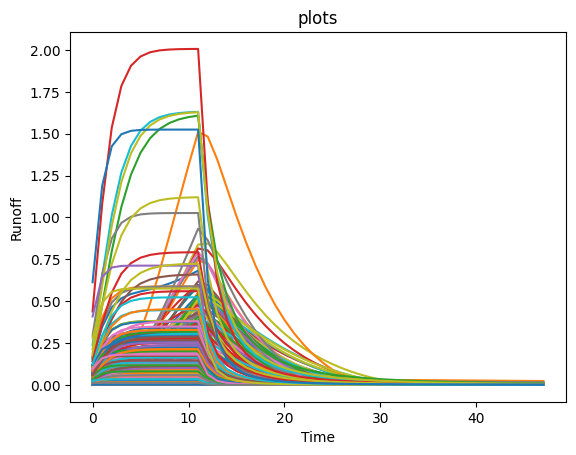

In [35]:

#read txt
path_txt = 'C:/Users/sylvi/Documents/Hyspec4EO/for_dsieo/for_dsieo/b_1y_runoff_swmm.txt'
# Set the file name
file_name = 'C:/Users/sylvi/Documents/Hyspec4EO/for_dsieo/for_dsieo/berlin_runoff.tif'
data_txt = []
data_txt_sum = []
for point_id in subs.index:

    data_txt.append(np.loadtxt(path_txt, skiprows=1,usecols=point_id+1))
    data_txt_sum.append(sum_data_5min(data_txt[point_id]))

data_txt = np.array(data_txt)
data_txt_sum = np.array(data_txt_sum)

print(data_txt.shape)
print(data_txt_sum.shape)
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('plots')
ax.set_xlabel('Time')
ax.set_ylabel('Runoff')
for i in range(0,subs.shape[0]):
    ax.plot(data_txt_sum[i])

plt.show()


In [48]:

width = extent[2] - extent[0]
height = extent[3] - extent[1]
print(width,height)
new_map = np.zeros((math.ceil(height),math.ceil(width),data_txt_sum.shape[1]))

for px in range(0,math.ceil(width)):
    for py in range(0,math.ceil(height)):
        new_map[math.ceil(height)-py-1,px] = get_nearest_runoff_value(px,py,data_txt_sum,subs,extent)


3212.1689999999944 2726.9873999999836


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 3213, 'height': 2727, 'count': 48, 'crs': CRS.from_epsg(25833), 'transform': Affine(1.0, 0.0, 391688.1352,
       0.0, -1.0, 5819450.5491), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}
EPSG:25833
| 1.00, 0.00, 391688.14|
| 0.00,-1.00, 5819450.55|
| 0.00, 0.00, 1.00|
BoundingBox(left=391688.1352, bottom=5816723.5491, right=394901.1352, top=5819450.5491)
3213
2727
48
-9999.0


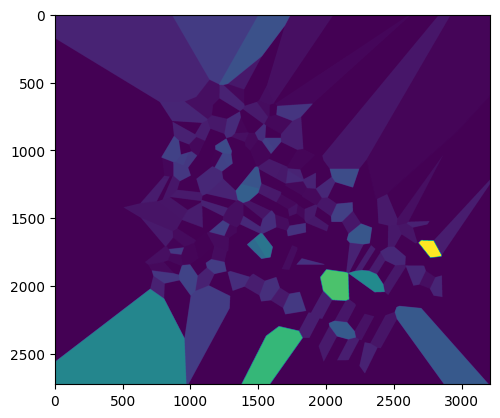

In [51]:
#save to tif with projection

file_name = 'C:/Users/sylvi/Documents/Hyspec4EO/for_dsieo/for_dsieo/berlin_runoff1.tif'
def save_to_tif(extent,file_path,image):

    # Set the transform with the upper left corner and the pixel size
    transform = from_origin(extent[0], extent[3], 1, 1)
    save_new_map = image.transpose(2,0,1)
    # Set the metadata
    meta = {
    'driver': 'GTiff',
    'height': save_new_map.shape[1],
    'width': save_new_map.shape[2],
    'count': save_new_map.shape[0],
    'dtype': save_new_map.dtype,
    'crs': CRS.from_epsg(25833),
    'transform': transform,
    'compress': 'lzw',
    'nodata': -9999
    }

    # Write the raster to disk
    with rasterio.open(file_name, 'w', **meta) as dst:
        dst.write(save_new_map, indexes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48])
        dst.nodata = -9999
        dst.crs = CRS.from_epsg(25833)
        dst.transform = transform
        dst.close()

    # Open the raster file
    with rasterio.open(file_name) as src:
        print(src.profile)
        print(src.crs)
        print(src.transform)
        print(src.bounds)
        print(src.width)
        print(src.height)
        print(src.count)
        print(src.nodata)
        data = src.read(1)
        plt.imshow(data)
        plt.show()

save_to_tif(extent,file_name,new_map)

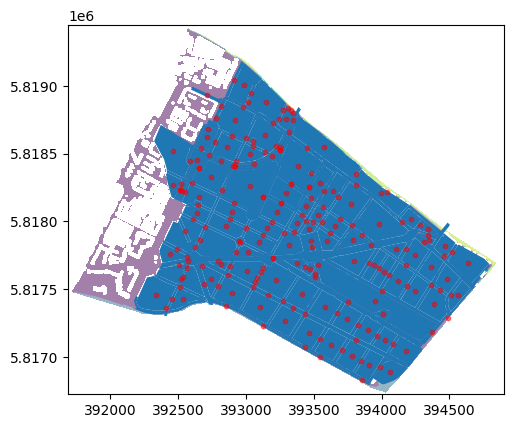

In [53]:
ax = subs.plot()


#plot the raster on the same plot
src = rasterio.open(file_name)
plt.imshow(data, extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top], alpha=0.5)
# Plot the center points on the same plot
subs['center_point'].plot(ax=ax, color='red', markersize=10, alpha=0.5)
plt.show()

In [ ]:

def sum_data_5min(data):
    t=len(data)
    data_30s = np.zeros((t-1))
    for i in range(0,t-1):
        data_30s[i] = (data[i]+data[i+1])/2*30
    timestep = 10
    output = np.zeros((math.ceil(t/timestep)))
    for i in range(0,math.ceil(t/timestep)):
        output[i] = np.sum(data_30s[i*timestep:(i+1)*timestep])
    return output

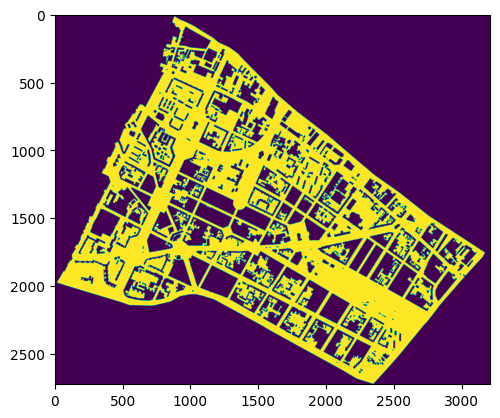

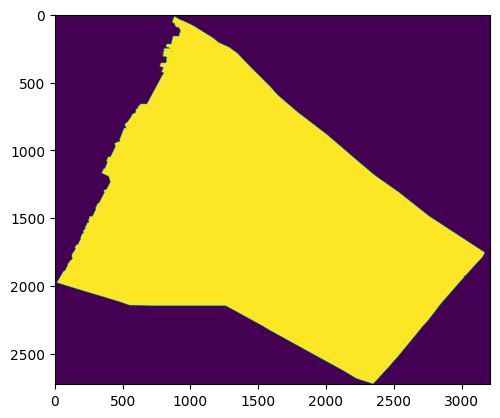

C:\Users\sylvi\AppData\Local\Temp\ipykernel_42820\1558061716.py:15: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave('mask.tif', mask1)


In [24]:
#make a mask
mask = np.zeros(data.shape)
mask1 = np.zeros(data.shape)
mask[data>=0]=1
plt.imshow(mask)
plt.show()
for i in range(0, mask.shape[0]):
    list=np.where(mask[i]==1)
    if len(list[0])>0:
        left = min(np.where(mask[i]==1)[0])
        right = max(np.where(mask[i]==1)[0])
        mask1[i][left:right]=1
plt.imshow(mask1)
plt.show()
tifffile.imsave('mask.tif', mask1)